### Google's Page Rank be applied to the covid_19 papers?

In [1]:
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
papers = pd.read_csv("covid19_papers_compiled.csv")

In [3]:
#load in authors and citations as list
with open("covid_authors_list.txt", "rb") as fp:
    b = pickle.load(fp)
papers['Authors'] = b
with open("covid_citations_list.txt", "rb") as fp:
    b = pickle.load(fp)
papers['Citations'] = b

In [4]:
#filter out only english ones
papers = papers[papers['Language'] == 'en']

In [5]:
#drop papers without any titles
papers = papers[papers['Titles'].notnull()]

In [6]:
papers.iloc[635]['Titles']

'Exhaled Air Dispersion During Oxygen Delivery Via a Simple Oxygen Mask*'

Create string matcher

In [7]:
#pull all possible citations
all_citations = []
for i in range(0,len(papers)):
    citations = papers['Citations'].iloc[i]
    for foo in citations:
        paper = foo[0]
        year = foo[1]
        paper_year = paper + " " + str(year)
        all_citations.append(paper_year)
        

In [8]:
len(all_citations)

1398382

In [9]:
len(set(all_citations))

917982

In [10]:
1398382 - 917982

480400

For a total of 23515 papers, they share a unique set of 917982 papers. Does that make sense?

In [11]:
917982 // 25315

36

This implies that each paper has an average of 36 citations to it?
Asked Sarah, this somes about right.

However, we only want to make the transition matrix with papers that are common to the list of all papers all possible citations. We need to make this square

In [12]:
#pull all possible citations
all_titles = []
for i in range(0,len(papers)):
    citations = papers['Citations'].iloc[i]
    for foo in citations:
        paper = foo[0]
        all_titles.append(paper)

In [13]:
len(all_titles)

1398382

In [14]:
len(set(list(papers['Titles'])).intersection(set(all_titles)))

6495

* Our Matrix will only be $6495 \times 6495$.
* Lets subset so that we only. have those papers!

In [15]:
common_papers = set(list(papers['Titles'])).intersection(set(all_titles))

In [18]:
sum(papers['Titles'].isin(common_papers))

6597

In [19]:
papers = papers[papers['Titles'].isin(common_papers)]

In [20]:
papers.shape

(6597, 10)

### Generate Transition Matrix
* where a row is a paper
* columns are citations
* i,j entry is where citation of a paper is in a paper
* i could use sklearn countvectorizer, but i want to avoid using a dependency on this project
* derive from first principles

In [27]:
def create_title(x):
    all_citations = []
    for foo in x:
        paper = foo[0]
        all_citations.append(paper)
    return(all_citations)
    
    

In [28]:
papers['Title_Year'] = papers['Citations'].apply(create_title)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
papers['Title_Year'].iloc[9][0]

'Epidemiological determinants of spread of causal agent of severe acute respiratory syndrome in Hong Kong'

In [33]:
citations_per_paper = list(papers['Title_Year'])

In [37]:
len(citations_per_paper),len(papers['Titles'])

(6597, 6597)

In [49]:
from scipy import sparse
#test to create sparse matrix
transition_matrix = np.zeros((len(citations_per_paper),len(papers)))

In [50]:
transition_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
set_all_citations = list(papers['Titles'])

In [52]:
#only need to go across rows
for i in range(0,len(citations_per_paper)-1):
    #pull citations for i'th paper
    ith_citations = citations_per_paper[i]
    #search across ith_citations, to get indices
    indices = []
    for j in range(0, len(ith_citations)-1):
        if ith_citations[j] in list(common_papers):
            index = set_all_citations.index(ith_citations[j])
            indices.append(index)
        else:
            pass
    #update entries in transition matrix
    for idx in indices:
        transition_matrix[i,idx] = 1 

### Notes and Transition Matrix and Citation Rank
* Citation Rank is very similiar to how google uses its page rank
* We begin with the tranistion matrix, $M$, which is $M\times N$
* An element $M_{ij}$ in this matrix is flagged with a 1
* This indicates that there is a connection between the $i'th$ paper in the corpus and the $j'th$ paper in the citations
* We can normalize this matrix across all citations in the row:
    * $M_{ij} = \frac{M_{ij}}{\sum_{j}^{N} \delta(M_{ij},1) = 1} $ 
    * $\delta$ is the indicator function where $M_{ij} =1$, or just row sum noramlized to get proabilites, which are all uniform
* We can call this normalized matrix $M$ as $M^*$
* There is a nifty little derivation that says if you multiple $M^*$ $n$ times as $n \to \infty$, we would reach a steady state, where the probabilites would not differ much
* We can factorize $M*$ into matrices D,M, and P:
    * $D = P M^* P^{-1}$ 
    * this just means $M^*$ can be diagonlized
    * for any number $n$ we can write:
    * $P D^n P^{-1} = M^n$
* Since D is diagonal, matrix mulplyting it n times is the same as exponentiating each term in the diagonal n times
* The whole point was to multiply $M^*$ n times, this can be easiliy done my first diagnolizaing M, which is can be done by solving the eigen value problem for $M*$
    * which is $M^{*T} v = \lambda v$
* M has a really nice property since its stochastic, where the leading eigenvalue has an upper bound of 1, we can take the eigenvector with the leading eigenvalue of 1
* This would give us the relative ranking for all papers, just sort that eigenvector

In [44]:
transition_matrix

<6597x6597 sparse matrix of type '<class 'numpy.float64'>'
	with 12197 stored elements in LInked List format>

In [54]:
print('Percent Sparsity is ',1-np.round((12197 / 6597**2)*100,2))

Percent Sparsity is  0.97


In [48]:
np.zeros((len(citations_per_paper),len(citations_per_paper))).nbytes*1e-9

0.348163272

### Stochastic Matrices
* normalize so that the column sum is equal to 1

In [63]:
#go across columns
for i in range(0,transition_matrix.shape[0]-1):
    #get column sum
    col_sum = np.sum(transition_matrix[:,i])
    if col_sum > 0.0:
        #normalize elements
        for j in range(0,len(transition_matrix[:,i])-1):
            transition_matrix[j,i] = transition_matrix[j,i] / col_sum
    else:
        pass
        

about 8 hours

### Check that colum sums to 1

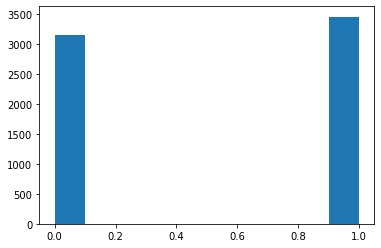

In [75]:
import matplotlib.pyplot as plt
plt.hist(transition_matrix.sum(axis=0))
plt.show()

In [76]:
np.max(transition_matrix.sum(axis=0))

1.000000000000002

### Solve the eigen value problem

In [172]:
w,v = np.linalg.eig(transition_matrix)

### Find eigenvalues greater than 0

In [173]:
w[w>0] 

array([0.70710678, 0.28867513, 1.        , 0.35355339, 0.70710678,
       0.28867513, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.5       ,
       1.        , 1.        , 1.        , 0.33333333, 1.        ,
       1.        , 1.        , 1.        , 0.5       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.2       , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.25      , 1.        , 1.        , 1.        , 1.        ])

The eigenvalues have are exactly correspond to papers that did not have any citations to any another papers in the transition matrix. Grab the eigen values that are greater than zero but less than one!

In [174]:
w[(w>0) & (w <1)]

array([0.70710678, 0.28867513, 0.35355339, 0.70710678, 0.28867513,
       0.5       , 0.33333333, 0.5       , 0.2       , 0.25      ])

In [175]:
np.where((w>0) & (w <1))

(array([ 291,  293,  297,  299,  301, 1819, 2457, 3787, 4714, 5508]),)

In [176]:
article_rankings = pd.DataFrame({'score':v[:,291],'paper': set_all_citations})
article_rankings.sort_values('score',ascending=False).head(10)

,score,paper
6195,0.707107,Specific mutations in H5N1 mainly impact the m...
6531,0.500000,New Metrics for Evaluating Viral Respiratory P...
3847,0.500000,Moving H5N1 studies into the era of systems bi...
0,0.000000,Airborne bioaerosols and their impact on human...
4404,0.000000,Influence of age and body condition on astrovi...
4403,0.000000,Development of a novel detection system for mi...
4402,0.000000,Endogenous ribosomal frameshift signals operat...
4401,0.000000,ALV-J strain SCAU-HN06 induces innate immune r...
4400,0.000000,The reproductive number of COVID-19 is higher ...
4399,0.000000,Community Case Clusters of Middle East Respira...


From an initial observation it would like as if papers in the same eigenvector of a certain eigen value are similiar (they most likely cited each other I believe).  Lets write a script that goes through of the the selected eigen values, and pull the papers that correspond to the cited eigenvector and examin them!

In [208]:
eig_vals_needed = np.where((w>0) & (w <1))
for i in range(0,len(eig_vals_needed[0])-1):
    print('For the eigenvalue of', w[eig_vals_needed[0][i]])
    print('==================')
    article_rankings = pd.DataFrame({'score':v[:,eig_vals_needed[0][i]],'paper': set_all_citations})
    #grab only the first ten
    article_rankings = article_rankings.sort_values('score',ascending=False).head(10)
    print('The scores and papers are: ')
    for j in range(0,len(article_rankings)):
        score = article_rankings['score'].iloc[j]
        paper = article_rankings['paper'].iloc[j]
        print(score,paper)
    print('\n')
        
    

For the eigenvalue of 0.7071067811865476
The scores and papers are: 
0.7071067811865475 Specific mutations in H5N1 mainly impact the magnitude and velocity of the host response in mice
0.5 New Metrics for Evaluating Viral Respiratory Pathogenesis
0.5 Moving H5N1 studies into the era of systems biology
0.0 Airborne bioaerosols and their impact on human health
0.0 Influence of age and body condition on astrovirus infection of bats in Singapore: An evolutionary and epidemiological analysis
0.0 Development of a novel detection system for microbes from bovine diarrhea by real-time PCR
0.0 Endogenous ribosomal frameshift signals operate as mRNA destabilizing elements through at least two molecular pathways in yeast
0.0 ALV-J strain SCAU-HN06 induces innate immune responses in chicken primary monocyte-derived macrophages
0.0 The reproductive number of COVID-19 is higher compared to SARS coronavirus
0.0 Community Case Clusters of Middle East Respiratory Syndrome Coronavirus in Hafr Al-Batin, K

### Notes
* For some of the groupings of papers, you would expect them to share citations among one another
* I had to drop a lot of papers because I didn't do string matching for all paper titles among citations
* I'm only matching papers in the corpus to citations that are papers in the corpus
* I could have had the full 29000~ by 29000~ matrix
* But reduced to 6700 by 6700 ish

In [182]:
for foo in eig_vals_needed:
    print(foo)

[ 291  293  297  299  301 1819 2457 3787 4714 5508]


In [185]:
eig_vals_needed[0][0]

291

In [201]:
len(article_rankings)

10